In [1]:
import pandas as pd

import os
import pickle
import numpy as np

import scipy
import scipy.sparse as sp
import scipy.io as spio

import isolearn.io as isoio
import isolearn.keras as iso

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.lines as pltl

from analyze_random_mpra_isoform_logodds_ratios_helpers import *


Using TensorFlow backend.


In [2]:
#Load plasmid data
plasmid_dict = isoio.load('../data/random_mpra_legacy/combined_library/processed_data_lifted/apa_plasmid_data_legacy')
df = plasmid_dict['plasmid_df']
cuts = plasmid_dict['plasmid_cuts']

#Filter data on sublibrary Alien2
keep_index = np.nonzero(df['library_index'] == 20)[0]
df = df.iloc[keep_index].copy().reset_index(drop=True)
cuts = cuts[keep_index, :]

#Filter on min read count
keep_index = np.nonzero(df['total_count'] >= 6)[0]
df = df.iloc[keep_index].copy().reset_index(drop=True)
cuts = cuts[keep_index, :]

print('n = ' + str(len(df)))


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


n = 602450


In [3]:
df = mask_constant_sequence_regions(df)
df = align_on_cse(df)

In [4]:
#Initialize hexamer count data generator (separated by USE, CSE and DSE regions)

hexamer_gen = iso.DataGenerator(
    np.arange(len(df), dtype=np.int),
    {
        'df' : df
    },
    batch_size=len(df),
    inputs = [
        {
            'id' : 'use',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: row['seq_var_aligned'][:50],
            'encoder' : iso.NMerEncoder(n_mer_len=6, count_n_mers=True),
            'sparse' : True,
            'sparse_mode' : 'col'
        },
        {
            'id' : 'cse',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: row['seq_var_aligned'][50:56],
            'encoder' : iso.NMerEncoder(n_mer_len=6, count_n_mers=True),
            'sparse' : True,
            'sparse_mode' : 'col'
        },
        {
            'id' : 'dse',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: row['seq_var_aligned'][56:96],
            'encoder' : iso.NMerEncoder(n_mer_len=6, count_n_mers=True),
            'sparse' : True,
            'sparse_mode' : 'col'
        }
    ],
    outputs = [
        {
            'id' : 'proximal_usage',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: row['proximal_count'] / row['total_count'],
            'transformer' : lambda t: t
        }
    ],
    randomizers = [],
    shuffle = False,
)

In [5]:
#Generate hexamer occurrence count matrices and corresponding isoform proportions
[X_use, X_cse, X_dse], y = hexamer_gen[0]
y = y[0]

In [8]:
#Compute Log Odds Ratios (with bootstrapped CI:s)

#Upstream
w_upstream, w_upstream_bootstrap = get_logodds_ratios(X_use, y, n_bootstraps=5, min_occurrence=100)

#PAS
w_pas, w_pas_bootstrap = get_logodds_ratios(X_cse, y, n_bootstraps=5, min_occurrence=1000)

#Downstream
w_downstream, w_downstream_bootstrap = get_logodds_ratios(X_dse, y, n_bootstraps=5, min_occurrence=100)

Performing bootstrap 0
Performing bootstrap 1
Performing bootstrap 2
Performing bootstrap 3
Performing bootstrap 4
Performing bootstrap 0
Performing bootstrap 1
Performing bootstrap 2
Performing bootstrap 3
Performing bootstrap 4
Performing bootstrap 0
Performing bootstrap 1
Performing bootstrap 2
Performing bootstrap 3
Performing bootstrap 4


USE Region (Unique 4-mers).


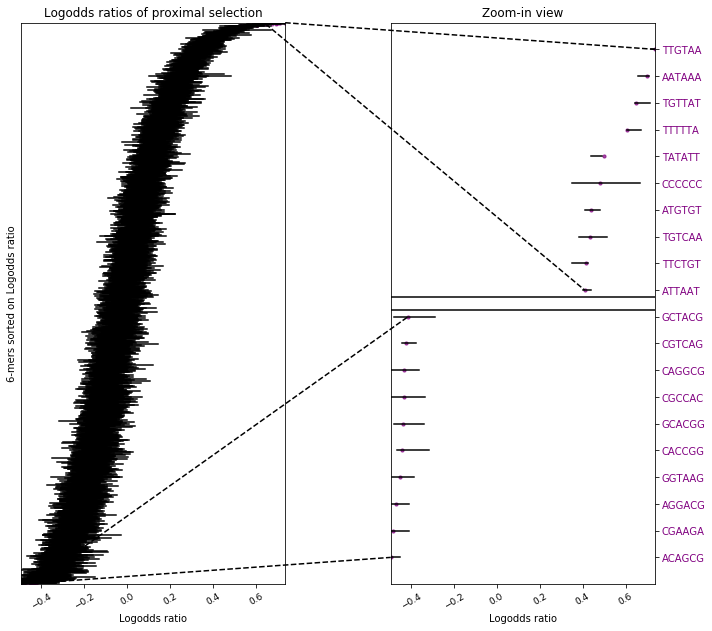

USE Region.


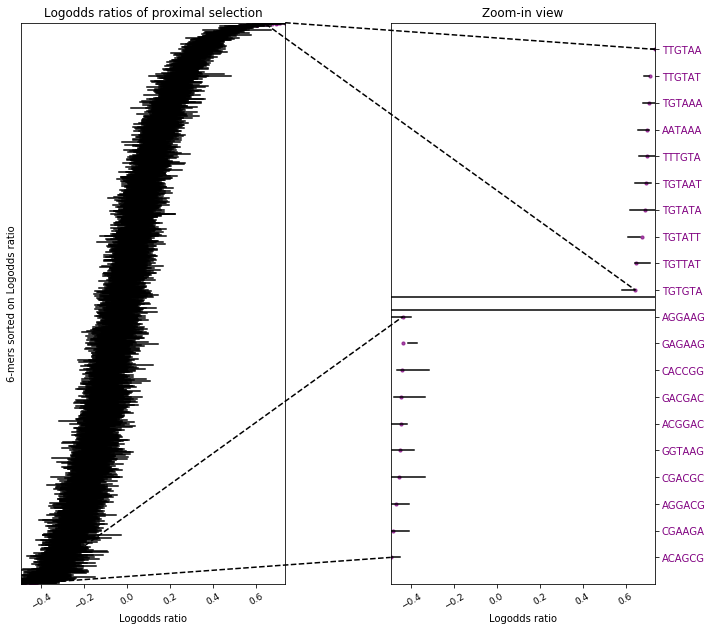

CSE Region.


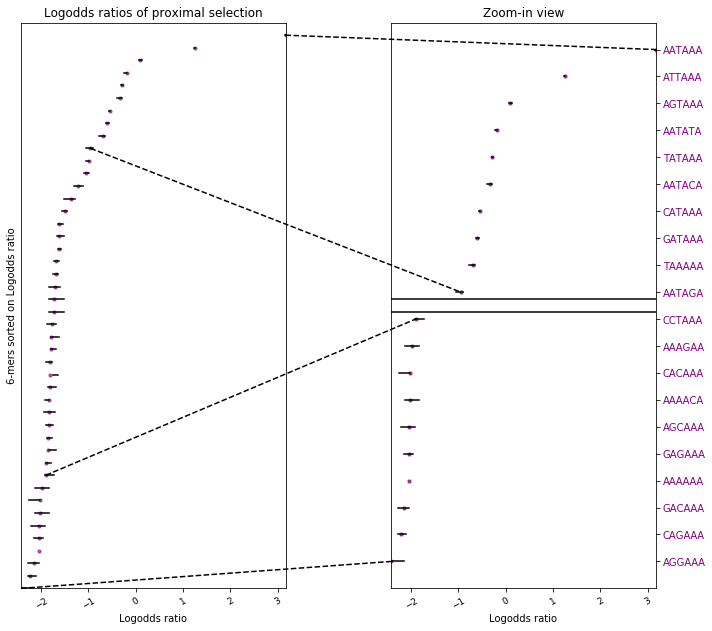

DSE Region (Unique 4-mers).


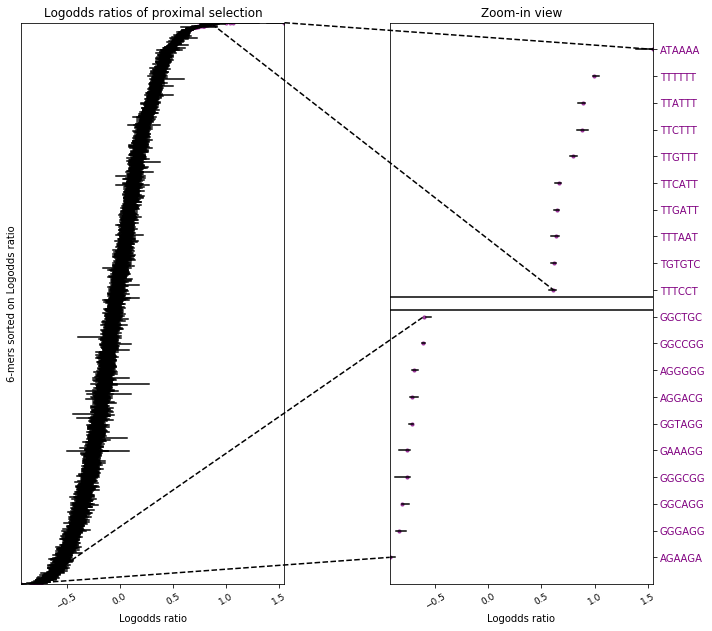

DSE Region.


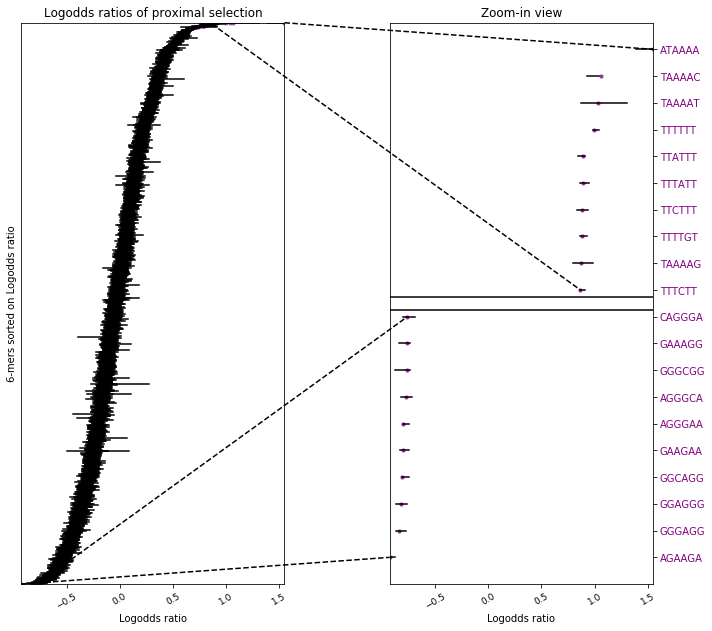

In [9]:
#All libraries
#Upstream
print("USE Region (Unique 4-mers).")
plot_logodds_ratios(w_upstream, w_upstream_bootstrap, unique4mer=True)
print("USE Region.")
plot_logodds_ratios(w_upstream, w_upstream_bootstrap, unique4mer=False)

#CSE
print("CSE Region.")
plot_logodds_ratios(w_pas, w_pas_bootstrap)

#Downstream
print("DSE Region (Unique 4-mers).")
plot_logodds_ratios(w_downstream, w_downstream_bootstrap, unique4mer=True)
print("DSE Region.")
plot_logodds_ratios(w_downstream, w_downstream_bootstrap, unique4mer=False)